In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
)
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier


def main():
    # 1. Load HealthStory dataset
    df = pd.read_csv("fakehealth_healthrelease.csv")

    # Make sure there are no missing texts
    df["text"] = df["text"].fillna("")

    X = df["text"]
    y = df["label"]          # 0 = fake, 1 = real

    # 2. Train / test split (stratified)
    X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        test_size=0.2,
        stratify=y,
        random_state=42,
    )

    # 3. Define models
    models = {
        "Logistic Regression": LogisticRegression(
            max_iter=1000,
            n_jobs=-1,
            class_weight="balanced",  # helpful if labels are imbalanced
        ),
        "Linear SVM": LinearSVC(
            class_weight="balanced",
        ),
        "Random Forest": RandomForestClassifier(
            n_estimators=300,
            max_depth=None,
            n_jobs=-1,
            random_state=42,
        ),
        "KNN": KNeighborsClassifier(
            n_neighbors=5,
        ),
        "Multinomial NB": MultinomialNB(),
        "Decision Tree": DecisionTreeClassifier(
            random_state=42,
        ),
        "XGBoost": XGBClassifier(
            n_estimators=300,
            learning_rate=0.1,
            max_depth=6,
            subsample=0.8,
            colsample_bytree=0.8,
            objective="binary:logistic",
            eval_metric="logloss",
            n_jobs=-1,
            random_state=42,
            use_label_encoder=False,
        ),
    }

    # 4. Shared TF-IDF vectorizer (word + bigram)
    # We'll put this inside each pipeline so everything is clean & self-contained
    def make_pipeline(clf):
        return Pipeline(
            steps=[
                (
                    "tfidf",
                    TfidfVectorizer(
                        ngram_range=(1, 2),
                        min_df=5,
                        max_df=0.9,
                        strip_accents="unicode",
                    ),
                ),
                ("clf", clf),
            ]
        )

    results = []

    # 5. Train & evaluate each model
    for name, clf in models.items():
        print("=" * 60)
        print(f"Training {name}...")
        pipe = make_pipeline(clf)
        pipe.fit(X_train, y_train)

        y_pred = pipe.predict(X_test)

        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)          # binary F1 (for class 1)
        f1_macro = f1_score(y_test, y_pred, average="macro")

        print(f"\n{name} – Accuracy: {acc:.4f}, F1 (macro): {f1_macro:.4f}")
        print("\nClassification report (0=fake, 1=real):")
        print(classification_report(y_test, y_pred, digits=4))

        results.append(
            {
                "model": name,
                "accuracy": acc,
                "f1_macro": f1_macro,
                "f1_real_class": f1,
            }
        )

    # 6. Comparison table
    print("\n" + "#" * 60)
    print("Overall comparison")
    results_df = pd.DataFrame(results).sort_values(
        by="f1_macro", ascending=False
    )
    print(results_df.to_string(index=False))

    # Optional: save the table
    results_df.to_csv("healthstory_model_comparison.csv", index=False)
    print("\nSaved comparison to healthstory_model_comparison.csv")


if __name__ == "__main__":
    main()


Training Logistic Regression...

Logistic Regression – Accuracy: 0.6050, F1 (macro): 0.6010

Classification report (0=fake, 1=real):
              precision    recall  f1-score   support

           0     0.6000    0.5263    0.5607        57
           1     0.6087    0.6774    0.6412        62

    accuracy                         0.6050       119
   macro avg     0.6043    0.6019    0.6010       119
weighted avg     0.6045    0.6050    0.6027       119

Training Linear SVM...

Linear SVM – Accuracy: 0.5882, F1 (macro): 0.5878

Classification report (0=fake, 1=real):
              precision    recall  f1-score   support

           0     0.5690    0.5789    0.5739        57
           1     0.6066    0.5968    0.6016        62

    accuracy                         0.5882       119
   macro avg     0.5878    0.5879    0.5878       119
weighted avg     0.5886    0.5882    0.5884       119

Training Random Forest...

Random Forest – Accuracy: 0.5546, F1 (macro): 0.5526

Classification re

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [16:26:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



XGBoost – Accuracy: 0.5378, F1 (macro): 0.5366

Classification report (0=fake, 1=real):
              precision    recall  f1-score   support

           0     0.5179    0.5088    0.5133        57
           1     0.5556    0.5645    0.5600        62

    accuracy                         0.5378       119
   macro avg     0.5367    0.5366    0.5366       119
weighted avg     0.5375    0.5378    0.5376       119


############################################################
Overall comparison
              model  accuracy  f1_macro  f1_real_class
Logistic Regression  0.605042  0.600985       0.641221
         Linear SVM  0.588235  0.587770       0.601626
     Multinomial NB  0.596639  0.586087       0.652174
      Random Forest  0.554622  0.552600       0.582677
            XGBoost  0.537815  0.536637       0.560000
      Decision Tree  0.521008  0.520873       0.512821
                KNN  0.436975  0.436816       0.427350

Saved comparison to healthstory_model_comparison.csv


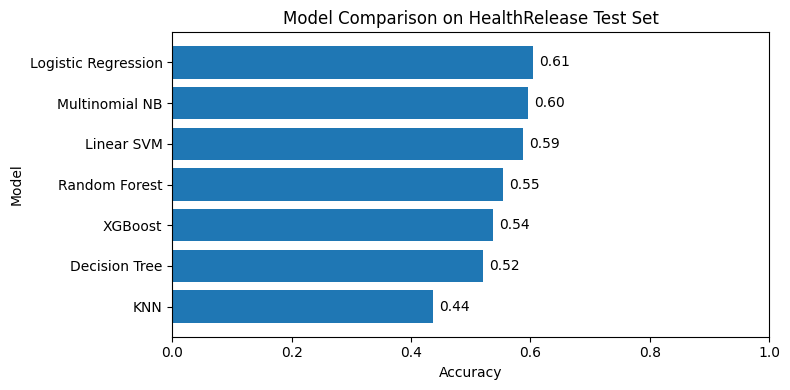

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Load the comparison results
df = pd.read_csv("healthstory_model_comparison.csv")

# 2. Sort by accuracy so the best model is at the top of the chart
df_sorted = df.sort_values("accuracy", ascending=True)

# 3. Make the bar plot
plt.figure(figsize=(8, 4))
plt.barh(df_sorted["model"], df_sorted["accuracy"])

plt.xlabel("Accuracy")
plt.ylabel("Model")
plt.title("Model Comparison on HealthRelease Test Set")
plt.xlim(0, 1)  # accuracy between 0 and 1

# 4. Optional: add accuracy values at the end of each bar
for i, (acc, model) in enumerate(zip(df_sorted["accuracy"], df_sorted["model"])):
    plt.text(acc + 0.01, i, f"{acc:.2f}", va="center")

plt.tight_layout()
plt.show()


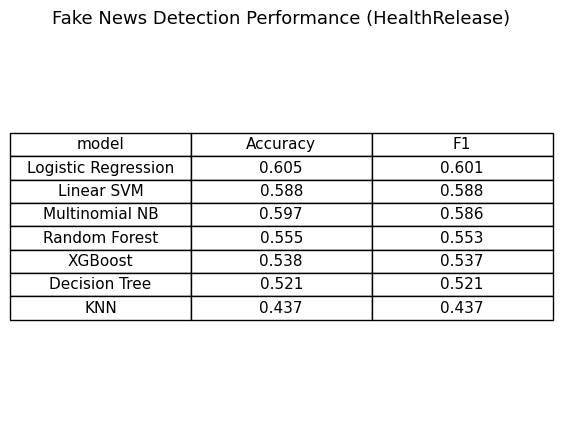

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# Load results
df = pd.read_csv("healthstory_model_comparison.csv")

# Format values like the paper
df_plot = df.copy()
df_plot["Accuracy"] = df_plot["accuracy"].round(3)
df_plot["F1"] = df_plot["f1_macro"].round(3)

# Keep only needed columns
df_plot = df_plot[["model", "Accuracy", "F1"]]

# Create figure
fig, ax = plt.subplots(figsize=(7, len(df_plot) * 0.7))
ax.axis("off")

table = ax.table(
    cellText=df_plot.values,
    colLabels=df_plot.columns,
    loc="center",
    cellLoc="center"
)

# Style like a research paper
table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1, 1.4)

plt.title("Fake News Detection Performance (HealthRelease)", fontsize=13, pad=10)
plt.show()
